# Model Prediksi Covid-19 Di Indonesia Menggunakan Regresi Linier dan Tensorflow

**Dibuat oleh : Nurhayati, Ph.D**

Pada webinar kali ini, kita akan membuat visualisasi data dan analisa statistik tentang pandemi covid-19 di Indonesia.\
Sumber data dari:
[Satgas Penanganan Covid-19 Republik Indonesia](https://bnpb-inacovid19.hub.arcgis.com/search?collection=Dataset/ "InaCOVID-19") (* Update 20 Oktober 2020)

Kebutuhan Pokok Library
1. StatsModels
2. Scikit-Learn
3. Tensorflow

## Input dataset time series Covid-19 Indonesia

In [12]:
# Deklarasi Pustaka
import datetime # => format custom tanggalan
import numpy as np # => menghitung numerik
import pandas as pd # => membuat dataset menjadi data frame
import matplotlib.pyplot as plt # => viisualisasi datanya

# => proses analisa statistik
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

# => proses model prediksi dengan pendekatan Machine Learning
from sklearn.linear_model import LinearRegression

# => proses Optimizer dengan Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

In [13]:
# Load dataset
# ket. data sudah di pra-proses (seleksi fitur dan reduksi dimensi)
dataset = pd.read_excel("dataset/dataset_covid.xlsx", sheet_name="data covid indonesia")

# melihat tipe data yang terbaca oleh python
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tanggal               232 non-null    datetime64[ns]
 1   positif_kumulatif     232 non-null    int64         
 2   sembuh_kumulatif      232 non-null    int64         
 3   meninggal_kumulatif   232 non-null    int64         
 4   positif_harian        232 non-null    int64         
 5   sembuh_harian         232 non-null    int64         
 6   meninggal_harian      232 non-null    int64         
 7   perawatan_kumulatif   232 non-null    int64         
 8   perawatan_harian      232 non-null    int64         
 9   persentase_sembuh     232 non-null    float64       
 10  persentase_meninggal  232 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(8)
memory usage: 20.1 KB


In [14]:
# Melihat dataset
dataset

,tanggal,positif_kumulatif,sembuh_kumulatif,meninggal_kumulatif,positif_harian,sembuh_harian,meninggal_harian,perawatan_kumulatif,perawatan_harian,persentase_sembuh,persentase_meninggal
0,2020-03-02,2,0,0,2,0,0,2,2,0.000000,0.000000
1,2020-03-03,2,0,0,0,0,0,2,0,0.000000,0.000000
2,2020-03-04,2,0,0,0,0,0,2,0,0.000000,0.000000
3,2020-03-05,2,0,0,0,0,0,2,0,0.000000,0.000000
4,2020-03-06,4,0,0,2,0,0,4,2,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
227,2020-10-15,349160,273661,12268,4411,5810,112,63231,-1511,78.376962,3.513575
228,2020-10-16,353461,277544,12347,4301,3883,79,63570,339,78.521817,3.493172
229,2020-10-17,357762,281592,12431,4301,4048,84,63739,169,78.709310,3.474656
230,2020-10-18,361867,285324,12511,4105,3732,80,64032,293,78.847753,3.457348


## Mengenali Data Covid-19

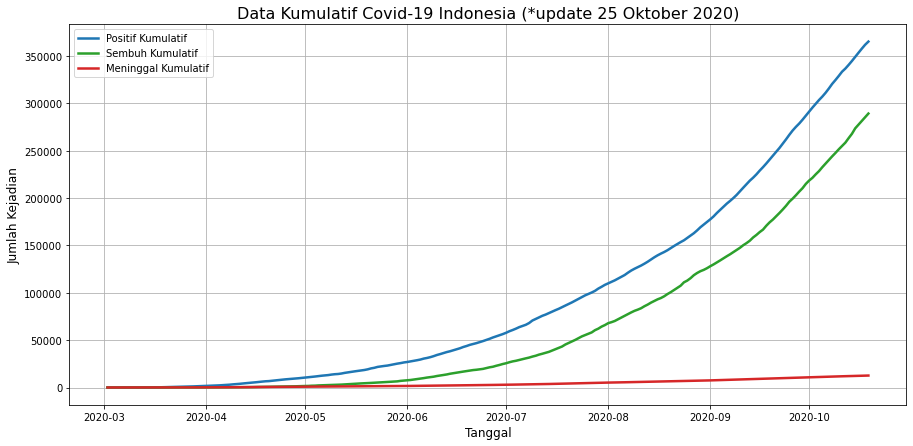

In [15]:
# Membuat plot time series data kumulatif Covid-19

# membuat frame
fig, ax = plt.subplots(figsize=(15, 7))

# membuat time series plot
ax.plot(dataset.tanggal, dataset.positif_kumulatif, color='tab:blue', label='Positif Kumulatif', linewidth=2.5)
ax.plot(dataset.tanggal, dataset.sembuh_kumulatif, color='tab:green', label='Sembuh Kumulatif', linewidth=2.5)
ax.plot(dataset.tanggal, dataset.meninggal_kumulatif, color='tab:red', label='Meninggal Kumulatif', linewidth=2.5)

# membuat label-label
ax.set_title('Data Kumulatif Covid-19 Indonesia (*update 25 Oktober 2020)', fontsize=16)
ax.set_xlabel('Tanggal', fontsize=12)
ax.set_ylabel('Jumlah Kejadian', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True)

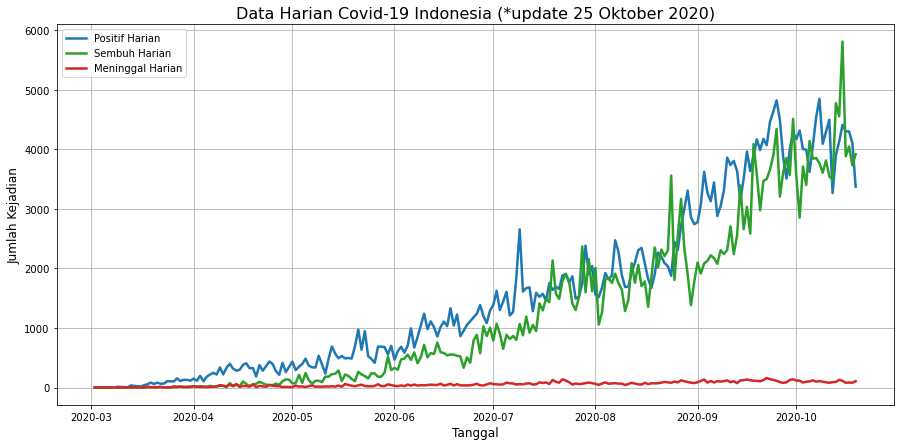

In [16]:
# Membuat plot time series data harian Covid-19
# membuat frame
fig, ax = plt.subplots(figsize=(15, 7))

# membuat time series plot
ax.plot(dataset.tanggal, dataset.positif_harian, color='tab:blue', label='Positif Harian', linewidth=2.5)
ax.plot(dataset.tanggal, dataset.sembuh_harian, color='tab:green', label='Sembuh Harian', linewidth=2.5)
ax.plot(dataset.tanggal, dataset.meninggal_harian, color='tab:red', label='Meninggal Harian', linewidth=2.5)

# membuat label-label
ax.set_title('Data Harian Covid-19 Indonesia (*update 25 Oktober 2020)', fontsize=16)
ax.set_xlabel('Tanggal', fontsize=12)
ax.set_ylabel('Jumlah Kejadian', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True)

## Agregrasi Data dan Analisa Linieritas 

In [65]:
# Membuat plot time series data positif Covid-19 menjadi data harian, data mingguan dan data bulanan
# Memisahkan variabel tanggal dan positif harian
df = dataset[["tanggal", "positif_harian", "sembuh_harian", "meninggal_harian"]]

# Membuat index data. Agar mudah dalam melakukan aggregasi.
# Metode yang digunakan adalah resampling
df = df.set_index("tanggal")

# Menampilkan hasil index data berdasarkan tanggal
df.tail()

,positif_harian,sembuh_harian,meninggal_harian
tanggal,,,
2020-10-15,4411,5810,112
2020-10-16,4301,3883,79
2020-10-17,4301,4048,84
2020-10-18,4105,3732,80
2020-10-19,3373,3919,106


In [66]:
# proses aggregasi ke data mingguan
df_mingguan = df.resample('W').sum()
df_mingguan.tail()

,positif_harian,sembuh_harian,meninggal_harian
tanggal,,,
2020-09-27,30537,25687,833
2020-10-04,28285,25439,765
2020-10-11,29951,26574,693
2020-10-18,28418,30297,667
2020-10-25,3373,3919,106


In [67]:
# proses aggregasi ke data bulanan
df_bulanan = df.resample('M').sum()
df_bulanan.tail()

,positif_harian,sembuh_harian,meninggal_harian
tanggal,,,
2020-06-30,29912,17498,1263
2020-07-31,51991,41101,2255
2020-08-31,66420,60052,2286
2020-09-30,112212,88988,3323
2020-10-31,78232,74296,1877


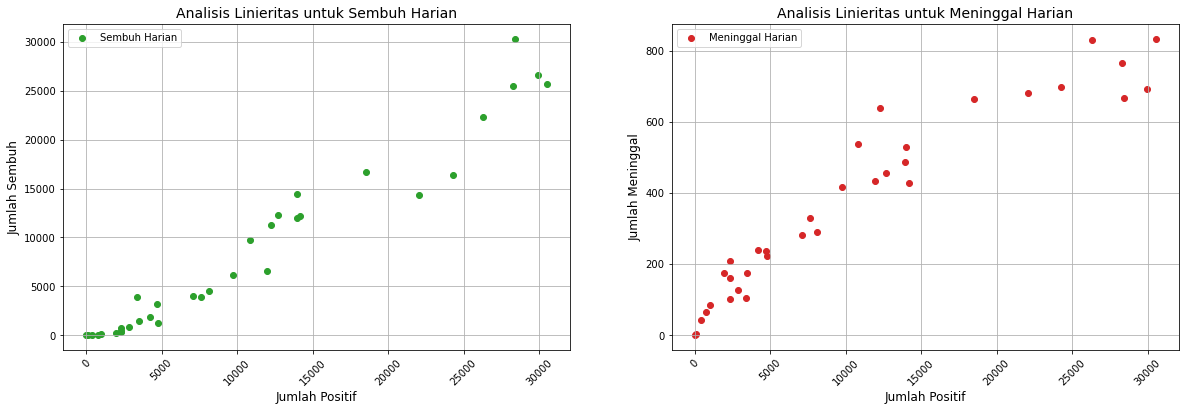

In [68]:
##------------------------------------------------------------------------------------------------------------
# Melihat pergerakan variabel bebas dengan variabel terikat
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))

# Membuat plot 2
ax1.scatter(df_mingguan["positif_harian"], df_mingguan["sembuh_harian"], color='tab:green', label='Sembuh Harian')

# membuat label-label plot 2
ax1.set_title('Analisis Linieritas untuk Sembuh Harian', fontsize=14)
ax1.set_xlabel('Jumlah Positif', fontsize=12)
ax1.set_ylabel('Jumlah Sembuh', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True)

# Membuat plot 3
ax2.scatter(df_mingguan["positif_harian"], df_mingguan["meninggal_harian"], color='tab:red', label='Meninggal Harian')

# membuat label-label plot 3
ax2.set_title('Analisis Linieritas untuk Meninggal Harian', fontsize=14)
ax2.set_xlabel('Jumlah Positif', fontsize=12)
ax2.set_ylabel('Jumlah Meninggal', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True)

# rotasi label x menjadi 45 derajat
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Menampilkan Hasil Visualisasi
plt.show()

## Proses- Regresi Linier

In [69]:
# Membuat model regresi linier sederhana
model_lin = sm.OLS.from_formula("sembuh_harian ~ positif_harian", data=df_mingguan)
result_lin = model_lin.fit()

# Menampilkan hasil regresi
print(result_lin.summary())

                            OLS Regression Results                            
Dep. Variable:          sembuh_harian   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     684.8
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           3.56e-23
Time:                        15:18:25   Log-Likelihood:                -305.01
No. Observations:                  34   AIC:                             614.0
Df Residuals:                      32   BIC:                             617.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1296.4805    503.695     -2.

In [70]:
# Membuat model regresi linier sederhana
model_lin = sm.OLS.from_formula("meninggal_harian ~ positif_harian", data=df_mingguan)
result_lin = model_lin.fit()

# Menampilkan hasil regresi
print(result_lin.summary())

                            OLS Regression Results                            
Dep. Variable:       meninggal_harian   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     304.1
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           6.69e-18
Time:                        15:18:26   Log-Likelihood:                -196.50
No. Observations:                  34   AIC:                             397.0
Df Residuals:                      32   BIC:                             400.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        102.5414     20.706      4.

In [71]:
# Memisahkan variabel-variabel nya
positif_harian = df_mingguan["positif_harian"]
sembuh_harian = df_mingguan["sembuh_harian"]
meninggal_harian = df_mingguan["meninggal_harian"]

In [72]:
# transformasi data positif_harian
positif_harian_matrix = positif_harian.values.reshape(-1,1)
positif_harian_matrix

array([[    6],
       [  111],
       [  397],
       [  771],
       [  988],
       [ 1968],
       [ 2334],
       [ 2307],
       [ 2310],
       [ 2840],
       [ 3482],
       [ 4757],
       [ 4202],
       [ 4713],
       [ 7091],
       [ 7614],
       [ 8119],
       [ 9739],
       [11950],
       [10822],
       [12257],
       [12677],
       [13941],
       [14153],
       [13986],
       [18518],
       [22056],
       [24273],
       [26294],
       [30537],
       [28285],
       [29951],
       [28418],
       [ 3373]], dtype=int64)

In [73]:
# membuat model regresi
reg1 = LinearRegression()
reg1.fit(positif_harian_matrix,sembuh_harian)

reg2 = LinearRegression()
reg2.fit(positif_harian_matrix,meninggal_harian)

LinearRegression()

## Hasil Regresi Linier

In [74]:
# Membuat prediksi regresi dengan inputan x1
# Namun fungsi predict(parameter) menerima inputan nummpy array 2D
# Oleh karena itu masukan nya transformasi x1 menjadi x1 2D 
y1_hat = reg1.predict(positif_harian_matrix)
y2_hat = reg2.predict(positif_harian_matrix)


In [75]:
y1_hat

array([-1291.00481725, -1195.18028981,  -934.17252936,  -592.85468878,
        -394.81733207,   499.54492401,   833.56184822,   808.92125545,
         811.65909909,  1295.34480901,  1881.2433482 ,  3044.82689565,
        2538.32582205,  3004.67185558,  5174.8692484 ,  5652.16665649,
        6113.03700274,  7591.47256891,  9609.26333237,  8579.83412333,
        9889.43599831, 10272.73410806, 11426.27889549, 11619.75317946,
       11467.34655011, 15603.31567721, 18832.14594457, 20855.41239531,
       22699.80639484, 26572.02991785, 24516.82195796, 26037.2377933 ,
       24638.19969272,  1781.76836257])

In [76]:
y2_hat

array([102.69137596, 105.31625895, 112.46594024, 121.81552347,
       127.24028166, 151.73918958, 160.88878172, 160.21381181,
       160.28880847, 173.53821786, 189.58750243, 221.46108162,
       207.58670009, 220.36113065, 279.8084807 , 292.88289789,
       305.50733513, 346.00552986, 401.27806601, 373.07932301,
       408.9527239 , 419.45225587, 451.05084731, 456.35061107,
       452.17579716, 565.47074687, 653.91680425, 709.33933371,
       759.86208158, 865.93235334, 809.63486289, 851.28300636,
       812.95971468, 186.8626239 ])

## Visualisasi Regresi Linier

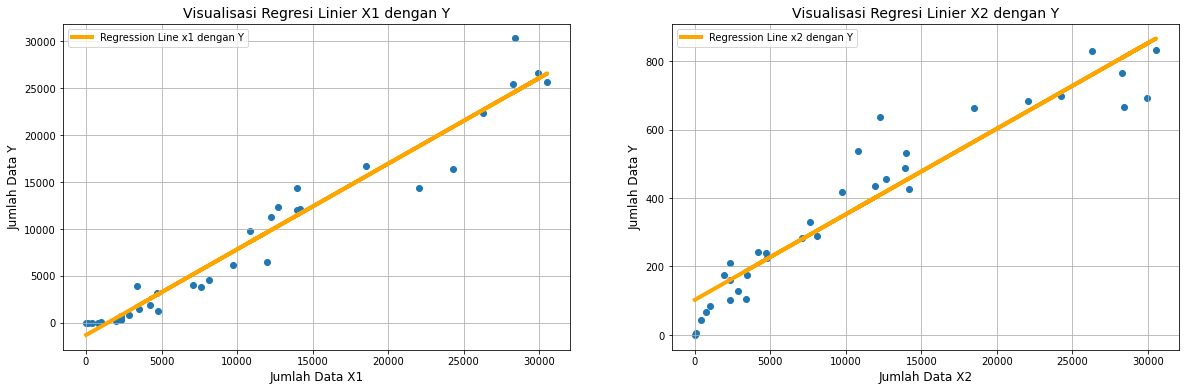

In [82]:
##------------------------------------------------------------------------------------------------------------
y1_hat = reg1.coef_*positif_harian_matrix+reg1.intercept_
y2_hat = reg2.coef_*positif_harian_matrix+reg2.intercept_

# Melihat pergerakan variabel bebas dengan variabel terikat
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))

# Membuat plot 1
ax1.scatter(positif_harian,sembuh_harian) # membuat garis regresi
ax1.plot(positif_harian, y1_hat, color='orange', label='Regression Line x1 dengan Y', lw=4)

# membuat label-label plot 1
ax1.set_title('Visualisasi Regresi Linier X1 dengan Y', fontsize=14)
ax1.set_xlabel('Jumlah Data X1', fontsize=12)
ax1.set_ylabel('Jumlah Data Y', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True)


# Membuat plot 2
ax2.scatter(positif_harian, meninggal_harian) # membuat garis regresi
ax2.plot(positif_harian, y2_hat, color='orange', label='Regression Line x2 dengan Y', lw=4)

# membuat label-label plot 2
ax2.set_title('Visualisasi Regresi Linier X2 dengan Y', fontsize=14)
ax2.set_xlabel('Jumlah Data X2', fontsize=12)
ax2.set_ylabel('Jumlah Data Y', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True)

# Menampilkan Hasil Visualisasi
plt.show()